## Automated anisotropic resistivity inversion for efficient formation evaluation and uncertainty quantification

### Misael M. Morales, Ali Eghbali, Oriyomi Raheem, Michael Pyrcz, Carlos Torres-Verdin
***
## Gradient-Based Inversion
***

In [5]:
from main import *

case1, case2, synthetic1, synthetic2 = load_all_data()

Name              : Source                : Shape
----------------- : --------------------- : -----------
Field Case 1      : (North Africa)        : (2399, 12)
Field Case 2      : (North Sea)           : (11143, 12)
Synthetic Case 1  : (Laminated)           : (801, 14)
Synthetic Case 2  : (Laminated+Dispersed) : (415, 10)


***
### Field Case 1

In [6]:
ali_cg = loadmat('Ali/sol.mat', simplify_cells=True)['sol']
ali_Csh = ali_cg[0,:]
ali_Rss = ali_cg[1,:]

ali_Rvsh = 2.78
ali_Rhsh = 0.60

Rv_sim_ali = ali_Csh*ali_Rvsh + (1-ali_Csh)*ali_Rss
Rh_sim_ali = 1/(ali_Csh/ali_Rhsh + (1-ali_Csh)/ali_Rss)

ali = pd.read_csv('Ali/RVRH.csv', header=None)
d = ali.iloc[1:2156, 0].values
c = ali.iloc[1:2156, 14].values
r = ali.iloc[1:2156, 15].values
ali_sol = pd.DataFrame({'Csh_ALI':c, 'Rss_ALI':r}, index=d)
ali_sol['Rv_sim_ALI'] = c*ali_Rvsh + (1-c)*r
ali_sol['Rh_sim_ALI'] = 1/(c/ali_Rhsh + (1-c)/r)

ali_results = {'Rv_sim': Rv_sim_ali, 'Rh_sim':Rh_sim_ali, 'Csh':ali_Csh, 'Rss':ali_Rss, 'df':ali}

In [7]:
d = lasio.read('cases/well1.las').df()[['CALI', 'AT10','AT30','AT60','AT90','GR','RV72H_1D_FLT','RH72H_1D_FLT']].dropna()
column_names = ['CALI', 'AT10', 'AT30', 'AT60', 'AT90', 'GR', 'Rv', 'Rh']

zstart = int(np.argwhere(d.index==9720).squeeze())
zend   = int(np.argwhere(d.index==10110).squeeze())
data = d.rename(columns=dict(zip(d.columns, column_names))).iloc[zstart:zend]

data['Rvsh'] = 2.813
data['Rhsh'] = 0.775
data['Csh_lin']  = (data['GR'] - data['GR'].min())/(data['GR'].max() - data['GR'].min())
qinv = np.abs(quadratic_inversion(data))
data = data.join(qinv)

data['Rvsh_win'] = np.nan_to_num(np.array(pd.Series(data['Rv']).rolling(250).max().tolist()), nan=data['Rv'].mean())
data['Rhsh_win'] = np.nan_to_num(np.array(pd.Series(data['Rh']).rolling(250).max().tolist()), nan=data['Rh'].mean())
R_min = np.min([data['Rh'].min(), data['Rv'].min()])
R_max = np.max([data['Rh'].max(), data['Rv'].max()])

data['Rvsh_win'] = 2.813
data['Rhsh_win'] = 0.775
print(data.shape)
data.head()

(1560, 15)


,CALI,AT10,AT30,AT60,AT90,GR,Rv,Rh,Rvsh,Rhsh,Csh_lin,Rss_q,Csh_q,Rvsh_win,Rhsh_win
DEPTH:1,,,,,,,,,,,,,,,
9720.00,12.8824,1.5269,1.1963,1.1103,1.1101,86.3898,3.8097,0.8607,2.813,0.775,0.850451,8.605069,0.151414,2.813,0.775
9720.25,12.8969,1.5301,1.2093,1.1268,1.1215,87.6158,3.8877,0.8783,2.813,0.775,0.866923,8.752324,0.148871,2.813,0.775
9720.50,12.9115,1.5334,1.2223,1.1433,1.1328,88.8418,3.9521,0.8921,2.813,0.775,0.883394,8.882588,0.146847,2.813,0.775
9720.75,12.8370,1.5219,1.2123,1.1382,1.1203,90.0982,3.9985,0.9017,2.813,0.775,0.900274,8.980526,0.145428,2.813,0.775
9721.00,12.7624,1.5104,1.2023,1.1331,1.1078,91.3546,4.0274,0.9076,2.813,0.775,0.917154,9.042526,0.144557,2.813,0.775


In [8]:
grmax, calimax = data['GR'].max(), data['CALI'].max()
lambda_reg = 1e-5
possible_methods = ['L-BFGS-B', 'TNC', 'SLSQP', 'trust-constr']

def objective(variables, *args):
    Csh, Rs = variables   
    Rv, Rh, Rvsh, Rhsh = args[0], args[1], args[2], args[3]
    grw, caliw = args[4]/grmax, args[5]/calimax
    
    def loss():
        eq1 = (Csh*Rvsh + (1-Csh)*Rs) - Rv
        eq2 = (Csh/Rhsh + (1-Csh)/Rs) - (1/Rh)
        return np.expand_dims(np.array([eq1, eq2]),-1)
    def weighting(method='gr'):
        if method=='gr':
            Wd1, Wd2 = 1/Rv/grw, 1*Rh/grw
        elif method=='cali':
            Wd1, Wd2 = 1/Rv/caliw, 1*Rh/caliw
        elif method=='data':
            Wd1, Wd2 = 1/Rv, 1*Rh
        elif method=='none':
            Wd1, Wd2 = 1, 1
        else:
            raise ValueError('Invalid weighting method')
        return np.diag(np.array([Wd1, Wd2]))
    def reg(v, a=0, o=2):
        return a*linalg.norm(v, o)
    
    cost = np.dot(weighting(), loss())
    return linalg.norm(cost,2) + reg(variables, a=lambda_reg)

def jacobian(variables, *args):
    return Jacobian(lambda x: objective(x, *args))(variables).ravel()

def hessian(variables, *args):
    return Hessian(lambda x: objective(x, *args))(variables)

bounds = [(0,1),(R_min,R_max)]
constr = (optimize.NonlinearConstraint(lambda x: x[0], lb=bounds[0][0], ub=bounds[0][1]),
          optimize.NonlinearConstraint(lambda x: x[1], lb=bounds[1][0], ub=bounds[1][1]))

xall, xhist  = {}, []
def callback(x, *args):
    xhist.append(x)

sol = []
for i, row in data.iterrows():
    Rv_value       = row['Rv']
    Rh_value       = row['Rh']
    Csh_lin_value  = row['Csh_lin']
    GR_value       = row['GR']
    CALI_value     = row['CALI']
    Rvsh_value     = 2.813 #row['Rvsh_win'] #2.8133
    Rhsh_value     = 0.775 #row['Rhsh_win'] #0.7746

    x0 = (Csh_lin_value, np.mean([Rv_value, Rh_value]))
    c0 = (Rv_value, Rh_value, Rvsh_value, Rhsh_value, GR_value, CALI_value)
    res = optimize.minimize(objective,
                            x0          = x0,
                            args        = c0,
                            method      = 'L-BFGS-B',
                            #jac         = jacobian,
                            #hess        = hessian,
                            bounds      = bounds,
                            #constraints = constr,
                            tol         = 1e-6,
                            callback    = callback,
                            options     = {'maxiter':100},
                            )
    Csh_pred, Rss_pred = res.x
    sol.append({'Rv':Rv_value, 'Rh':Rh_value, 
                'Csh_pred':Csh_pred, 'Rss_pred':Rss_pred,
                'fun':res.fun, 'nfev':res.nfev, 'jac_norm':linalg.norm(res.jac),
                'Rv_sim':Csh_pred*Rvsh_value + (1-Csh_pred)*Rss_pred,
                'Rh_sim':1/(Csh_pred/Rhsh_value + (1-Csh_pred)/Rss_pred)})
    xall[i] = np.array([x0]+xhist)

sol = pd.DataFrame(sol, index=data.index)
sol.to_csv('results/gradient_based_solution_field1.csv')

Mean Squared Error - Rv: 0.0406  | Rh: 0.0002
R2 Score           - Rv: 99.899  | Rh: 99.971
Standard Error     - Rv: 0.0465  | Rh: 0.1030
MAPE               - Rv: 0.073%  | Rh: 0.231%


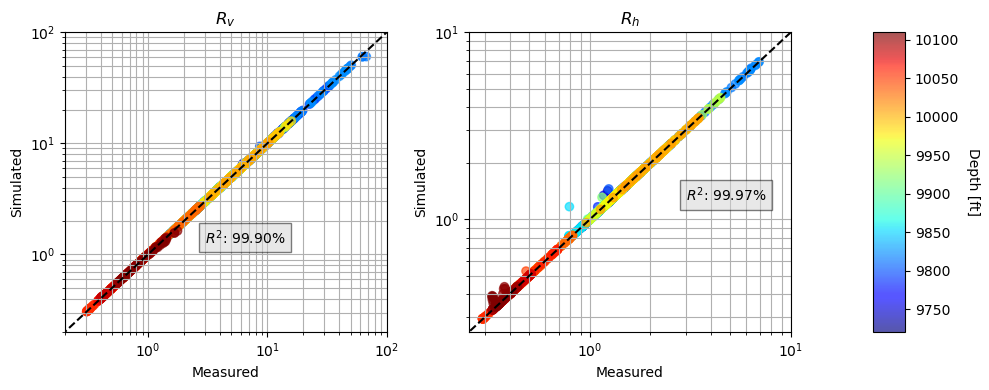

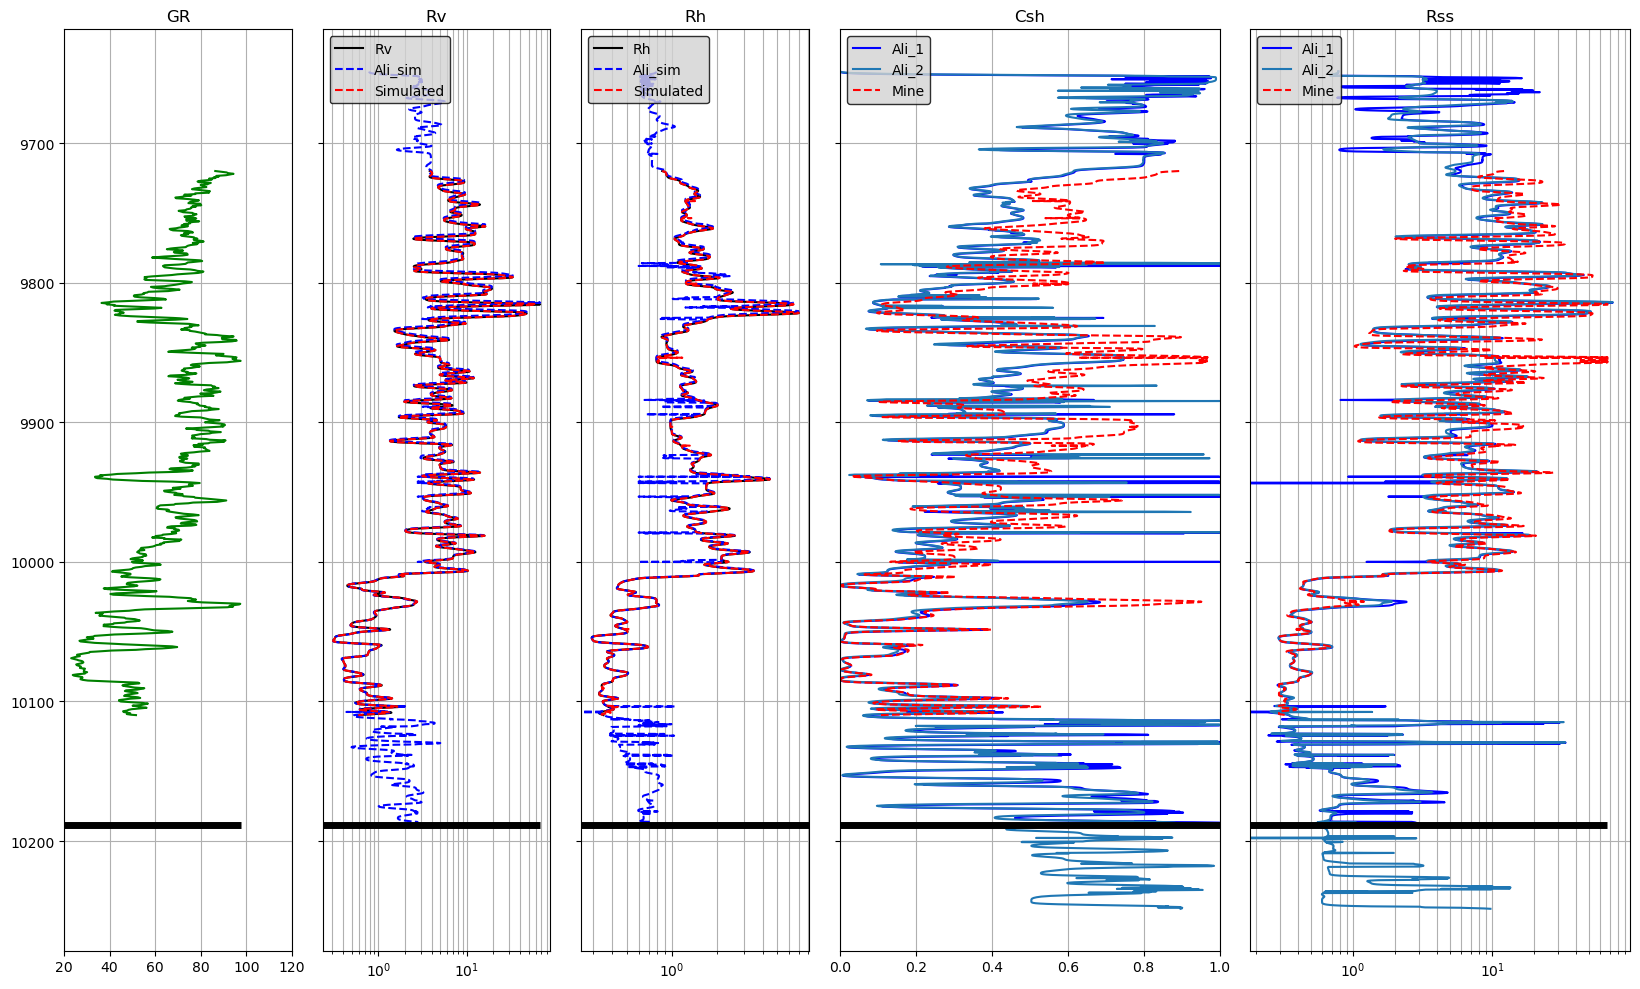

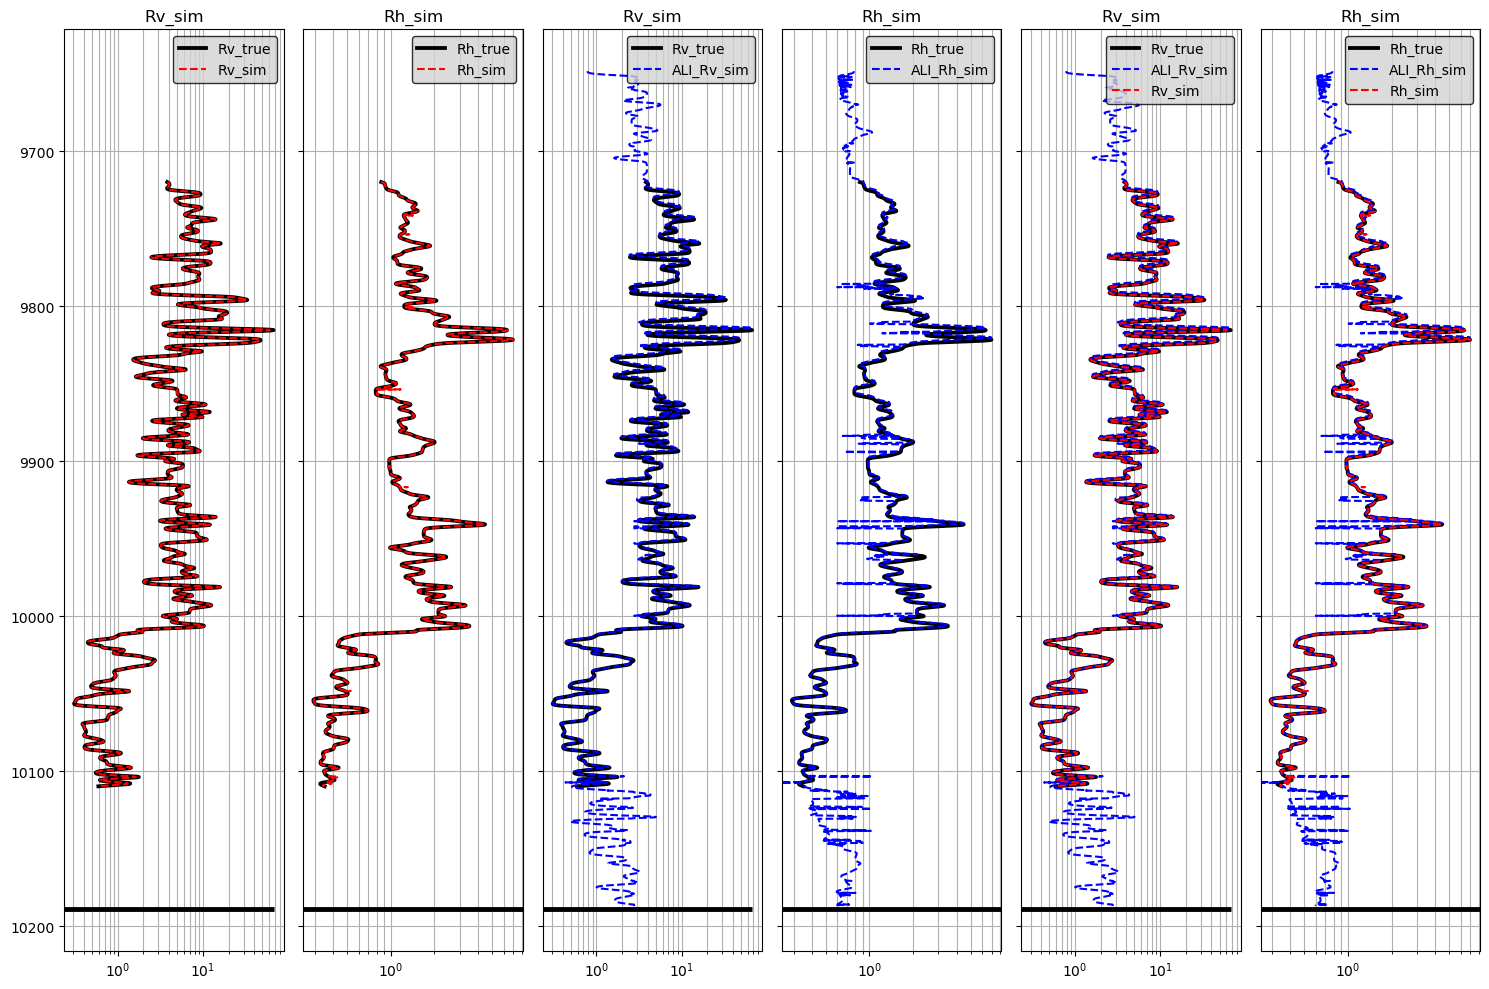

FileNotFoundError: [Errno 2] No such file or directory: 'well1.las'

In [9]:
error_metrics(sol)

plot_crossplot(sol)
plot_inversion_solution(data, sol, ali_results)
plot_inversion_comparison(sol, ali_results)
plot_inversion_fullsuite(data, sol, ali_sol)
plot_short_results(data, sol)

***
### Field Case 2

In [10]:
d = lasio.read('cases/well2.las').df()[['HCAL', 'AT10','AT30','AT60','AT90','HCGR','RV72_1DF','RH72_1DF']].dropna()
column_names = ['CALI', 'AT10', 'AT30', 'AT60', 'AT90', 'GR', 'Rv', 'Rh']

zstart = int(np.argwhere(d.index==6292.75).squeeze())
zend   = int(np.argwhere(d.index==9078.25).squeeze())
data = d.rename(columns=dict(zip(d.columns, column_names))).iloc[zstart:zend]

data['Rvsh'] = 2.78
data['Rhsh'] = 0.58
data['Csh_lin']  = (data['GR'] - data['GR'].min())/(data['GR'].max() - data['GR'].min())
qinv = np.abs(quadratic_inversion(data))
data = data.join(qinv)

data['Rvsh_win'] = np.nan_to_num(np.array(pd.Series(data['Rv']).rolling(250).max().tolist()), nan=data['Rv'].mean())
data['Rhsh_win'] = np.nan_to_num(np.array(pd.Series(data['Rh']).rolling(250).max().tolist()), nan=data['Rh'].mean())
R_min = np.min([data['Rh'].min(), data['Rv'].min()])
R_max = np.max([data['Rh'].max(), data['Rv'].max()])

data['Rvsh_win'] = 2.78
data['Rhsh_win'] = 0.58
print(data.shape)
data.head()

(11142, 15)


,CALI,AT10,AT30,AT60,AT90,GR,Rv,Rh,Rvsh,Rhsh,Csh_lin,Rss_q,Csh_q,Rvsh_win,Rhsh_win
DEPTH,,,,,,,,,,,,,,,
6292.75,10.4387,1.1217,0.8094,1.3978,1.0305,37.8765,1.4184,0.6011,2.78,0.58,0.216496,2.037415,0.175938,2.78,0.58
6293.00,11.4565,0.9908,0.6934,1.1127,0.7013,39.1862,1.4186,0.6011,2.78,0.58,0.224202,2.037837,0.175945,2.78,0.58
6293.25,12.3524,0.8676,0.5749,0.8996,0.6263,40.1169,1.4180,0.6008,2.78,0.58,0.229678,2.037901,0.175963,2.78,0.58
6293.50,12.9191,0.8490,0.5244,0.6579,0.4820,41.0475,1.4158,0.5997,2.78,0.58,0.235154,2.038138,0.176028,2.78,0.58
6293.75,13.4785,0.7455,0.5213,0.5982,0.4660,41.9985,1.4111,0.5975,2.78,0.58,0.240749,2.038006,0.176146,2.78,0.58


In [ ]:
grmax, calimax = data['GR'].max(), data['CALI'].max()
lambda_reg = 1e-5
possible_methods = ['L-BFGS-B', 'TNC', 'SLSQP', 'trust-constr']

def objective(variables, *args):
    Csh, Rs = variables   
    Rv, Rh, Rvsh, Rhsh = args[0], args[1], args[2], args[3]
    grw, caliw = args[4]/grmax, args[5]/calimax
    def loss():
        eq1 = (Csh*Rvsh + (1-Csh)*Rs) - Rv
        eq2 = (Csh/Rhsh + (1-Csh)/Rs) - (1/Rh)
        return np.expand_dims(np.array([eq1, eq2]),-1)
    def weighting(method='gr'):
        if method=='gr':
            Wd1, Wd2 = 1/Rv/grw, 1*Rh/grw
        elif method=='cali':
            Wd1, Wd2 = 1/Rv/caliw, 1*Rh/caliw
        elif method=='data':
            Wd1, Wd2 = 1/Rv, 1*Rh
        elif method=='none':
            Wd1, Wd2 = 1, 1
        else:
            raise ValueError('Invalid weighting method')
        return np.diag(np.array([Wd1, Wd2]))
    def reg(v, a=0, o=2):
        return a*linalg.norm(v, o)
    cost = np.dot(weighting(), loss())
    return linalg.norm(cost,2) + reg(variables, a=lambda_reg)

def jacobian(variables, *args):
    return Jacobian(lambda x: objective(x, *args))(variables).ravel()

def hessian(variables, *args):
    return Hessian(lambda x: objective(x, *args))(variables)

bounds = [(0,1),(R_min,R_max)]
constr = (optimize.NonlinearConstraint(lambda x: x[0], lb=bounds[0][0], ub=bounds[0][1]),
          optimize.NonlinearConstraint(lambda x: x[1], lb=bounds[1][0], ub=bounds[1][1]))

xall, xhist  = {}, []
def callback(x, *args):
    xhist.append(x)

sol = []
for i, row in data.iterrows():
    Rv_value       = row['Rv']
    Rh_value       = row['Rh']
    Csh_lin_value  = row['Csh_lin']
    GR_value       = row['GR']
    CALI_value     = row['CALI']
    Rvsh_value     = 2.78 #row['Rvsh_win'] #2.8133
    Rhsh_value     = 0.58 #row['Rhsh_win'] #0.7746

    x0 = (Csh_lin_value, np.mean([Rv_value, Rh_value]))
    c0 = (Rv_value, Rh_value, Rvsh_value, Rhsh_value, GR_value, CALI_value)
    res = optimize.minimize(objective,
                            x0          = x0,
                            args        = c0,
                            method      = 'L-BFGS-B',
                            #jac         = jacobian,
                            #hess        = hessian,
                            bounds      = bounds,
                            #constraints = constr,
                            tol         = 1e-6,
                            callback    = callback,
                            options     = {'maxiter':100},
                            )
    Csh_pred, Rss_pred = res.x
    sol.append({'Rv':Rv_value, 'Rh':Rh_value, 
                'Csh_pred':Csh_pred, 'Rss_pred':Rss_pred,
                'fun':res.fun, 'nfev':res.nfev, 'jac_norm':linalg.norm(res.jac),
                'Rv_sim':Csh_pred*Rvsh_value + (1-Csh_pred)*Rss_pred,
                'Rh_sim':1/(Csh_pred/Rhsh_value + (1-Csh_pred)/Rss_pred)})
    xall[i] = np.array([x0]+xhist)

sol = pd.DataFrame(sol, index=data.index)
sol.to_csv('results/gradient_based_solution_field2.csv')

In [ ]:
error_metrics(sol)

plot_crossplot(sol)

In [ ]:
fig, axs = plt.subplots(1, 8, figsize=(17.5,10), sharey=True)
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = axs

tempdf = lasio.read('well2.LAS').df()

ax11, ax12 = ax1.twiny(), ax1.twiny()
plot_curve(ax1, data, 'CALI', 12, 24, 'dodgerblue', units='in', fill=True, semilog=True, pad=0)
plot_curve(ax11, data, 'GR', 10, 150, 'g', units='API', pad=8)
plot_curve(ax12, sol, 'Csh_pred', 0, 1, 'r', units='v/v', s=1, pad=16)

ax21, ax22 = ax2.twiny(), ax2.twiny()
plot_curve(ax2, data, 'Csh_lin', 0, 1, 'k', units='v/v', pad=0)
plot_curve(ax21, data, 'Csh_q', 0, 1, 'gray', units='v/v', pad=8)
plot_curve(ax22, sol, 'Csh_pred', 0, 1, 'r', units='v/v', pad=16)

ax31, ax32 = ax3.twiny(), ax3.twiny()
plot_curve(ax3, tempdf, 'TNPH', 1, 0, 'b', units='PU', pad=0)
plot_curve(ax31, tempdf, 'RHOZ', 1.65, 2.65, 'maroon', units='g/cc', pad=8)
plot_curve(ax32, tempdf, 'PEFZ', -5, 5, 'm', units='b/e', pad=16)

ax41, ax42 = ax4.twiny(), ax4.twiny()
plot_curve(ax4, data, 'AT10', 0.2, 100, 'darkred', semilog=True, units='$\Omega\cdot m$', pad=0)
plot_curve(ax41, data, 'AT90', 0.2, 100, 'darkblue', semilog=True, units='$\Omega\cdot m$', pad=8)
plot_curve(ax42, sol, 'Rss_pred', 0.2, 100, 'r', semilog=True, units='$\Omega\cdot m$', pad=16)

ax51 = ax5.twiny()
plot_curve(ax5, tempdf, 'RV72_1DF', 0.2, 100, 'k', semilog=True, units='$\Omega\cdot m$', pad=0)
plot_curve(ax51, sol, 'Rv_sim', 0.2, 100, 'r', s=1, semilog=True, units='$\Omega\cdot m$', pad=8)

ax61 = ax6.twiny()
plot_curve(ax6, tempdf, 'RH72_1DF', 0.2, 100, 'k', semilog=True, units='$\Omega\cdot m$', pad=0)
plot_curve(ax61, sol, 'Rh_sim', 0.2, 100, 'r', s=1, semilog=True, units='$\Omega\cdot m$', pad=8)

ax71, ax72, ax73 = ax7.twiny(), ax7.twiny(), ax7.twiny()
plot_curve(ax7, data, 'Rv', 0.2, 100, 'k', s=4, semilog=True, units='$\Omega\cdot m$', pad=0)
plot_curve(ax71, sol, 'Rv_sim', 0.2, 100, 'darkred', ls='--', semilog=True, units='$\Omega\cdot m$', pad=8)
plot_curve(ax72, data, 'Rh', 0.2, 100, 'k', s=4, semilog=True, units='$\Omega\cdot m$', pad=16)
plot_curve(ax73, sol, 'Rh_sim', 0.2, 100, 'darkblue', ls='--', semilog=True, units='$\Omega\cdot m$', pad=24)

ax81, ax82 = ax8.twiny(), ax8.twiny()
plot_curve(ax8, sol, 'fun', 1e-6, 1e0, 'k', s=1, semilog=True, units='/', pad=0)
plot_curve(ax81, sol, 'jac_norm', 0, 5, 'darkmagenta', s=1, units='/', pad=8, alpha=0.5)
plot_curve(ax82, sol, 'nfev', 10, 150, 'darkgreen', s=1, units='/', pad=16, alpha=0.5)

ax1.invert_yaxis()
plt.tight_layout()
plt.show()

***
### Synthetic Case 1

In [ ]:
synthetic1['Csh_lin'] = (synthetic1['GR']-synthetic1['GR'].min())/(synthetic1['GR'].max()-synthetic1['GR'].min())
synthetic1 = synthetic1.join(np.abs(quadratic_inversion(synthetic1)))
print(synthetic1.shape)
synthetic1.head()

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(12,8), sharey=True)
ax1, ax2, ax3, ax4 = axs

ax11, ax12 = ax1.twiny(), ax1.twiny()
plot_curve(ax1, synthetic1, 'GR', lb=0, ub=100, color='g', units='API', marker='o')
plot_curve(ax11, synthetic1, 'Csh_lin', lb=0, ub=1, color='gray', units='v/v', pad=8)
plot_curve(ax12, synthetic1, 'Csh_q', lb=0, ub=1, color='black', units='v/v', pad=16)

ax21, ax22 = ax2.twiny(), ax2.twiny()
plot_curve(ax2, synthetic1, 'DPHI', lb=0.6, ub=0.0, color='r', units='v/v', marker='o')
plot_curve(ax21, synthetic1, 'NPHI', lb=0.6, ub=0.0, color='b', units='v/v', marker='o', pad=8)
plot_curve(ax22, synthetic1, 'PEF', lb=0, ub=10, color='k', ls='-.', units='b/e-', marker='o', pad=16)

ax31, ax32, ax33 = ax3.twiny(), ax3.twiny(), ax3.twiny()
plot_curve(ax3, synthetic1, 'AT10', lb=0.2, ub=200, color='b', units='$\Omega\cdot m$', semilog=True)
plot_curve(ax31, synthetic1, 'AT30', lb=0.2, ub=200, color='m', units='$\Omega\cdot m$', semilog=True, pad=8)
plot_curve(ax32, synthetic1, 'AT60', lb=0.2, ub=200, color='g', units='$\Omega\cdot m$', semilog=True, pad=16)
plot_curve(ax33, synthetic1, 'AT90', lb=0.2, ub=200, color='r', units='$\Omega\cdot m$', semilog=True, pad=24)

ax41 = ax4.twiny()
plot_curve(ax4, synthetic1, 'Rh', lb=0.2, ub=200, color='b', ls='--', units='$\Omega\cdot m$', semilog=True)
plot_curve(ax41, synthetic1, 'Rv', lb=0.2, ub=200, color='r', units='$\Omega\cdot m$', marker='o', semilog=True, pad=8)

[ax.grid(True, which='both') for ax in axs]
ax1.invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
sol = []
for i, row in synthetic1.iterrows():
    Rv_value       = row['Rv']
    Rh_value       = row['Rh']
    Csh_lin_value  = row['Csh_lin']
    GR_value       = row['GR']
    Rvsh_value     = 10 #row['Rvsh_win'] #2.8133
    Rhsh_value     = 1 #row['Rhsh_win'] #0.7746

    x0 = (Csh_lin_value, np.mean([Rv_value, Rh_value]))
    c0 = (Rv_value, Rh_value, Rvsh_value, Rhsh_value, GR_value, CALI_value)
    res = optimize.minimize(objective,
                            x0          = x0,
                            args        = c0,
                            method      = 'L-BFGS-B',
                            #jac         = jacobian,
                            #hess        = hessian,
                            bounds      = bounds,
                            #constraints = constr,
                            tol         = 1e-6,
                            callback    = callback,
                            options     = {'maxiter':100},
                            )
    Csh_pred, Rss_pred = res.x
    sol.append({'Rv':Rv_value, 'Rh':Rh_value, 
                'Csh_pred':Csh_pred, 'Rss_pred':Rss_pred,
                'fun':res.fun, 'nfev':res.nfev, 'jac_norm':linalg.norm(res.jac),
                'Rv_sim':Csh_pred*Rvsh_value + (1-Csh_pred)*Rss_pred,
                'Rh_sim':1/(Csh_pred/Rhsh_value + (1-Csh_pred)/Rss_pred)})
    xall[i] = np.array([x0]+xhist)

sol = pd.DataFrame(sol, index=synthetic1.index)
sol.to_csv('results/gradient_based_solution_synthetic1.csv')

In [ ]:
error_metrics(sol)

plot_crossplot(sol, cmap='Blues')

In [ ]:
fig = plt.figure(figsize=(12,10))
gs = GridSpec(2, 5, figure=fig, height_ratios=[1, 0.1])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
ax3 = fig.add_subplot(gs[0, 2], sharey=ax1)
ax4 = fig.add_subplot(gs[0, 3], sharey=ax1)
ax5 = fig.add_subplot(gs[0, 4], sharey=ax1)

ax3b = fig.add_subplot(gs[1, 2])
ax4b = fig.add_subplot(gs[1, 3])

ax11 = ax1.twiny()
plot_curve(ax1, synthetic1, 'GR', lb=0, ub=100, color='g', units='API', marker='o')
plot_curve(ax11, sol, 'Csh_pred', lb=-0.05, ub=1.05, color='k', units='v/v', pad=8)

ax21, ax22 = ax2.twiny(), ax2.twiny()
plot_curve(ax2, synthetic1, 'DPHI', lb=0.6, ub=0.0, color='r', units='v/v', marker='o')
plot_curve(ax21, synthetic1, 'NPHI', lb=0.6, ub=0.0, color='b', units='v/v', marker='o', pad=8)
plot_curve(ax22, synthetic1, 'PEF', lb=0, ub=10, color='m', units='b/e-', marker='o', pad=16)

ax31 = ax3.twiny()
plot_curve(ax3, synthetic1, 'Rh', lb=0.2, ub=200, color='b', units='$\Omega\cdot m$', semilog=True)
plot_curve(ax31, sol, 'Rh_sim', lb=0.2, ub=200, color='k', ls='--', units='$\Omega\cdot m$', semilog=True, pad=8)

ax41 = ax4.twiny()
plot_curve(ax4, synthetic1, 'Rv', lb=0.2, ub=200, color='r', units='$\Omega\cdot m$', semilog=True)
plot_curve(ax41, sol, 'Rv_sim', lb=0.2, ub=200, color='k', ls='--', units='$\Omega\cdot m$', semilog=True, pad=8)

ax51, ax52 = ax5.twiny(), ax5.twiny()
plot_curve(ax5, sol, 'Rh_sim', lb=0.2, ub=200, color='b', units='$\Omega\cdot m$', semilog=True)
plot_curve(ax51, sol, 'Rv_sim', lb=0.2, ub=200, color='r', units='$\Omega\cdot m$', semilog=True, pad=8)
plot_curve(ax52, sol, 'Rss_pred', lb=0.2, ub=200, color='k', units='$\Omega\cdot m$', semilog=True, pad=16)

ax3b.scatter(sol['Rv'], sol['Rv_sim'])
ax4b.scatter(sol['Rh'], sol['Rh_sim'])
[ax.set(xscale='log', yscale='log', xlabel='Measured', ylabel='Simulated') for ax in [ax3b, ax4b]]
ax3b.set(xlim=(0.2,100), ylim=(0.2,100))
ax4b.set(xlim=(0.25,10), ylim=(0.25,10))
[ax.axline((0.2,0.2), (100,100), color='k', ls='--') for ax in [ax3b, ax4b]]

[ax.grid(True, which='both') for ax in axs]
ax1.invert_yaxis()
plt.tight_layout()
plt.show()

***
### Synthetic Case 2

In [ ]:
synthetic2['Csh_lin'] = (synthetic2['GR']-synthetic2['GR'].min())/(synthetic2['GR'].max()-synthetic2['GR'].min())
synthetic2 = synthetic2.join(np.abs(quadratic_inversion(synthetic2)))

In [ ]:
print(synthetic2.shape)
synthetic2.head()

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(7,8), sharey=True)
ax1, ax2, ax3 = axs
ax11, ax12, ax21, ax22, ax31 = ax1.twiny(), ax1.twiny(), ax2.twiny(), ax2.twiny(), ax3.twiny()

plot_curve(ax1, synthetic2, 'GR', lb=15, ub=115, color='g', units='API')
plot_curve(ax11, synthetic2, 'Csh_lin', lb=0, ub=1, color='gray', units='v/v', pad=8)
plot_curve(ax12, synthetic2, 'Csh_q', lb=0, ub=1, color='black', units='v/v', pad=16)
plot_curve(ax2, synthetic2, 'RHOZ', lb=1.9, ub=2.9, color='r', units='g/cc')
plot_curve(ax21, synthetic2, 'NPOR', lb=0.6, ub=0.0, color='b', units='PU', pad=8)
plot_curve(ax22, synthetic2, 'PEFZ', lb=0, ub=10, color='m', units='b/e-', pad=16)
plot_curve(ax3, synthetic2, 'Rv', lb=0.8, ub=12.8, color='darkred', units='$\Omega\cdot m$', semilog=True)
plot_curve(ax31, synthetic2, 'Rh', lb=0.8, ub=12.8, color='darkblue', units='$\Omega\cdot m$', semilog=True, pad=8)

ax1.invert_yaxis()
[ax.grid(True, which='both') for ax in axs]
plt.tight_layout()
plt.show()

In [ ]:
sol = []
for i, row in synthetic2.iterrows():
    Rv_value       = row['Rv']
    Rh_value       = row['Rh']
    Csh_lin_value  = row['Csh_lin']
    GR_value       = row['GR']
    Rvsh_value     = 10 #row['Rvsh_win'] #2.8133
    Rhsh_value     = 1 #row['Rhsh_win'] #0.7746

    x0 = (Csh_lin_value, np.mean([Rv_value, Rh_value]))
    c0 = (Rv_value, Rh_value, Rvsh_value, Rhsh_value, GR_value, CALI_value)
    res = optimize.minimize(objective,
                            x0          = x0,
                            args        = c0,
                            method      = 'L-BFGS-B',
                            #jac         = jacobian,
                            #hess        = hessian,
                            bounds      = bounds,
                            #constraints = constr,
                            tol         = 1e-6,
                            callback    = callback,
                            options     = {'maxiter':100},
                            )
    Csh_pred, Rss_pred = res.x
    sol.append({'Rv':Rv_value, 'Rh':Rh_value, 
                'Csh_pred':Csh_pred, 'Rss_pred':Rss_pred,
                'fun':res.fun, 'nfev':res.nfev, 'jac_norm':linalg.norm(res.jac),
                'Rv_sim':Csh_pred*Rvsh_value + (1-Csh_pred)*Rss_pred,
                'Rh_sim':1/(Csh_pred/Rhsh_value + (1-Csh_pred)/Rss_pred)})
    xall[i] = np.array([x0]+xhist)

sol = pd.DataFrame(sol, index=synthetic2.index)
sol.to_csv('results/gradient_based_solution_synthetic2.csv')

In [ ]:
error_metrics(sol)

plot_crossplot(sol, cmap='Blues')

In [ ]:
fig = plt.figure(figsize=(12,10))
gs = GridSpec(2, 5, figure=fig, height_ratios=[1, 0.1])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
ax3 = fig.add_subplot(gs[0, 2], sharey=ax1)
ax4 = fig.add_subplot(gs[0, 3], sharey=ax1)
ax5 = fig.add_subplot(gs[0, 4], sharey=ax1)

ax3b = fig.add_subplot(gs[1, 2])
ax4b = fig.add_subplot(gs[1, 3])

ax11 = ax1.twiny()
plot_curve(ax1, synthetic2, 'GR', lb=0, ub=100, color='g', units='API', marker='o')
plot_curve(ax11, sol, 'Csh_pred', lb=-0.05, ub=1.05, color='k', units='v/v', pad=8)

ax21, ax22 = ax2.twiny(), ax2.twiny()
plot_curve(ax2, synthetic2, 'RHOZ', lb=1.9, ub=2.9, color='r', units='v/v', marker='o')
plot_curve(ax21, synthetic2, 'NPOR', lb=0.6, ub=0.0, color='b', units='v/v', marker='o', pad=8)
plot_curve(ax22, synthetic2, 'PEFZ', lb=0, ub=10, color='m', units='b/e-', marker='o', pad=16)

ax31 = ax3.twiny()
plot_curve(ax3, synthetic2, 'Rh', lb=0.2, ub=200, color='b', units='$\Omega\cdot m$', semilog=True)
plot_curve(ax31, sol, 'Rh_sim', lb=0.2, ub=200, color='k', ls='--', units='$\Omega\cdot m$', semilog=True, pad=8)

ax41 = ax4.twiny()
plot_curve(ax4, synthetic2, 'Rv', lb=0.2, ub=200, color='r', units='$\Omega\cdot m$', semilog=True)
plot_curve(ax41, sol, 'Rv_sim', lb=0.2, ub=200, color='k', ls='--', units='$\Omega\cdot m$', semilog=True, pad=8)

ax51, ax52 = ax5.twiny(), ax5.twiny()
plot_curve(ax5, sol, 'Rh_sim', lb=0.2, ub=200, color='b', units='$\Omega\cdot m$', semilog=True)
plot_curve(ax51, sol, 'Rv_sim', lb=0.2, ub=200, color='r', units='$\Omega\cdot m$', semilog=True, pad=8)
plot_curve(ax52, sol, 'Rss_pred', lb=0.2, ub=200, color='k', units='$\Omega\cdot m$', semilog=True, pad=16)

ax3b.scatter(sol['Rv'], sol['Rv_sim'])
ax4b.scatter(sol['Rh'], sol['Rh_sim'])
[ax.set(xscale='log', yscale='log', xlabel='Measured', ylabel='Simulated') for ax in [ax3b, ax4b]]
ax3b.set(xlim=(0.2,100), ylim=(0.2,100))
ax4b.set(xlim=(0.25,10), ylim=(0.25,10))
[ax.axline((0.2,0.2), (100,100), color='k', ls='--') for ax in [ax3b, ax4b]]

[ax.grid(True, which='both') for ax in axs]
ax1.invert_yaxis()
plt.tight_layout()
plt.show()

***
### Uncertainty Quantification

In [ ]:
d = lasio.read('well1.las').df()[['CALI', 'AT10','AT30','AT60','AT90','GR','RV72H_1D_FLT','RH72H_1D_FLT']].dropna()
column_names = ['CALI', 'AT10', 'AT30', 'AT60', 'AT90', 'GR', 'Rv', 'Rh']

zstart = int(np.argwhere(d.index==9720).squeeze())
zend   = int(np.argwhere(d.index==10110).squeeze())
data = d.rename(columns=dict(zip(d.columns, column_names))).iloc[zstart:zend]

data['Csh_lin']  = (data['GR'] - data['GR'].min())/(data['GR'].max() - data['GR'].min())
qinv = np.abs(quadratic_inversion(data))
data = data.join(qinv)

data['Rvsh_win'] = 2.78
data['Rhsh_win'] = 0.58
data

In [ ]:
grmax, calimax = data['GR'].max(), data['CALI'].max()
lambda_reg = 1e-5
n_realizations = 25

all_sol = []
for n in range(n_realizations):
    sol = []
    data['Rv'] = data['Rv'] + 0.1*data['Rv']*np.random.randn(len(data['Rv']))
    data['Rh'] = data['Rh'] + 0.1*data['Rh']*np.random.randn(len(data['Rh']))

    sol = []
    for i, row in data.iterrows():
        Rv_value       = row['Rv'] 
        Rh_value       = row['Rh']
        Csh_lin_value  = row['Csh_lin']
        GR_value       = row['GR']
        CALI_value     = row['CALI']
        Rvsh_value     = 2.813 #row['Rvsh_win'] #2.8133
        Rhsh_value     = 0.775 #row['Rhsh_win'] #0.7746

        x0 = (Csh_lin_value, np.mean([Rv_value, Rh_value]))
        c0 = (Rv_value, Rh_value, Rvsh_value, Rhsh_value, GR_value, CALI_value)
        res = optimize.minimize(objective,
                                x0          = x0,
                                args        = c0,
                                method      = 'L-BFGS-B',
                                #jac         = jacobian,
                                #hess        = hessian,
                                bounds      = bounds,
                                #constraints = constr,
                                tol         = 1e-6,
                                callback    = None, #callback
                                options     = {'maxiter':100},
                                )
        Csh_pred, Rss_pred = res.x
        sol.append({'Rv':Rv_value, 'Rh':Rh_value, 
                    'Csh_pred':Csh_pred, 'Rss_pred':Rss_pred,
                    'fun':res.fun, 'nfev':res.nfev, 'jac_norm':linalg.norm(res.jac),
                    'Rv_sim':Csh_pred*Rvsh_value + (1-Csh_pred)*Rss_pred,
                    'Rh_sim':1/(Csh_pred/Rhsh_value + (1-Csh_pred)/Rss_pred)})

    sol = pd.DataFrame(sol, index=data.index)

    all_sol.append(sol)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10,8), sharey=True)
ax1, ax2, ax3 = axs

ax11 = ax1.twiny()
ax1.plot(all_sol[0]['Rv'], all_sol[0].index)
ax1.plot(all_sol[0]['Rh'], all_sol[0].index)
ax11.plot(all_sol[0]['Csh_pred'], all_sol[0].index, c='k'); ax11.set(xlim=(0,1))

ax12 = ax2.twiny()
ax2.plot(all_sol[5]['Rv'], all_sol[5].index)
ax2.plot(all_sol[5]['Rh'], all_sol[5].index)
ax12.plot(all_sol[5]['Csh_pred'], all_sol[5].index, c='k'); ax11.set(xlim=(0,1))

ax13 = ax3.twiny()
ax3.plot(all_sol[9]['Rv'], all_sol[9].index)
ax3.plot(all_sol[9]['Rh'], all_sol[9].index)
ax13.plot(all_sol[9]['Csh_pred'], all_sol[9].index, c='k'); ax11.set(xlim=(0,1))

[ax.grid(True, which='both') for ax in axs]
[ax.set(xscale='log') for ax in axs]
ax1.invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
all_csh = np.array([sol['Csh_pred'] for sol in all_sol])
all_rss = np.array([sol['Rss_pred'] for sol in all_sol])
all_rv  = np.array([sol['Rv_sim'] for sol in all_sol])
all_rh  = np.array([sol['Rh_sim'] for sol in all_sol])

all_ensemble = [all_csh, all_rss, all_rv, all_rh]
all_titles   = ['Csh_pred', 'Rss_pred', 'Rv_sim', 'Rh_sim']

In [ ]:
fig, axs = plt.subplots(1, 6, figsize=(8,7), sharey=True)
ax1, ax2, ax3, ax4, ax5, ax6 = axs
colors = ['tab:pink', 'tab:orange', 'tab:red', 'tab:blue']

tstep = 50

ax21 = ax2.twiny()
plot_curve(ax1, case1, 'GR', 10, 110, color='g', units='API')
plot_curve(ax2, case1, 'Rv', 0.2, 100, color='darkred', units='$\Omega\cdot m$', semilog=True)
plot_curve(ax21, case1, 'Rh', 0.2, 100, color='darkblue', units='$\Omega\cdot m$', semilog=True, pad=8)


for i in range(n_realizations):
    for k in range(len(all_ensemble)):
        plot_curve(axs[k+2], all_sol[i], all_titles[k], color='gray', alpha=0.5)
        axs[k+2].plot(all_ensemble[k][i], all_sol[i].index, color=colors[k], lw=0.1)

[ax.grid(True, which='both') for ax in axs]
[ax.set(xscale='log') for ax in axs[[1,3,4,5]]]
axs[0].invert_yaxis()
plt.tight_layout()
plt.show()

***
# END